📥 Fetching data from Yahoo Finance...
📈 Fetching AAPL.NAS (AAPL)...
📈 Fetching AAVEUSD (AAVE-USD)...
📈 Fetching ABBV.NYSE (ABBV)...
📈 Fetching ABNB.NAS (ABNB)...
📈 Fetching ABT.NYSE (ABT)...
📈 Fetching ACN.NYSE (ACN)...
📈 Fetching ADAUSD (ADA-USD)...
📈 Fetching ADBE.NAS (ADBE)...
📈 Fetching ADS.XE (ADS.DE)...
📈 Fetching AI.EPA (AI.PA)...
📈 Fetching AIR.EPA (AIR.PA)...
📈 Fetching ALGOUSD (ALGO-USD)...
📈 Fetching ALV.XE (ALV.DE)...
📈 Fetching AMD.NAS (AMD)...
📈 Fetching AMZN.NAS (AMZN)...
📈 Fetching APTUSD (APT21794-USD)...
📈 Fetching ASML.EAS (ASML.AS)...
📈 Fetching ATOMUSD (ATOM-USD)...
📈 Fetching AUDCAD (AUDCAD=X)...
📈 Fetching AUDCHF (AUDCHF=X)...
📈 Fetching AUDJPY (AUDJPY=X)...
📈 Fetching AUDNZD (AUDNZD=X)...
📈 Fetching AUDUSD (AUDUSD=X)...
📈 Fetching AUS200 (^AXJO)...
📈 Fetching AVAXUSD (AVAX-USD)...
📈 Fetching AVGO.NAS (AVGO)...
📈 Fetching AXP.NYSE (AXP)...
📈 Fetching AXSUSD (AXS-USD)...
📈 Fetching AZN.LSE (AZN.L)...
📈 Fetching BA.NYSE (BA)...
📈 Fetching BABA.NYSE (BABA)...
📈 Fetc

c:\Users\syahr\Desktop\Portfolio\Trading\analyzer.py:198: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_chg = round(df["Close"].pct_change().abs().mean(), 7)



📊 Analyzing TMO.NYSE...

📊 Analyzing TMUS.NAS...

📊 Analyzing TRXUSD...

📊 Analyzing TSLA.NAS...

📊 Analyzing TTE.EPA...

📊 Analyzing TXN.NAS...

📊 Analyzing UCG.MIL...


c:\Users\syahr\Desktop\Portfolio\Trading\analyzer.py:198: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_chg = round(df["Close"].pct_change().abs().mean(), 7)



📊 Analyzing UK100...

📊 Analyzing UNH.NYSE...

📊 Analyzing UNIUSD...

📊 Analyzing UNP.NYSE...

📊 Analyzing UPS.NYSE...

📊 Analyzing US30...

📊 Analyzing USDCAD...

📊 Analyzing USDCHF...

📊 Analyzing USDJPY...

📊 Analyzing USDMXN...

📊 Analyzing USDZAR...

📊 Analyzing V.NYSE...

📊 Analyzing VNA.XE...

📊 Analyzing VOW3.XE...

📊 Analyzing VZ.NYSE...

📊 Analyzing WES.ASX...

📊 Analyzing WFC.NYSE...

📊 Analyzing WMT.NYSE...

📊 Analyzing XAGUSD...

📊 Analyzing XAUUSD...

📊 Analyzing XBRUSD...

📊 Analyzing XNGUSD...

📊 Analyzing XOM.NYSE...

📊 Analyzing XRPUSD...

📊 Analyzing XTIUSD...


c:\Users\syahr\Desktop\Portfolio\Trading\analyzer.py:198: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_chg = round(df["Close"].pct_change().abs().mean(), 7)



📊 Analyzing ZECUSD...


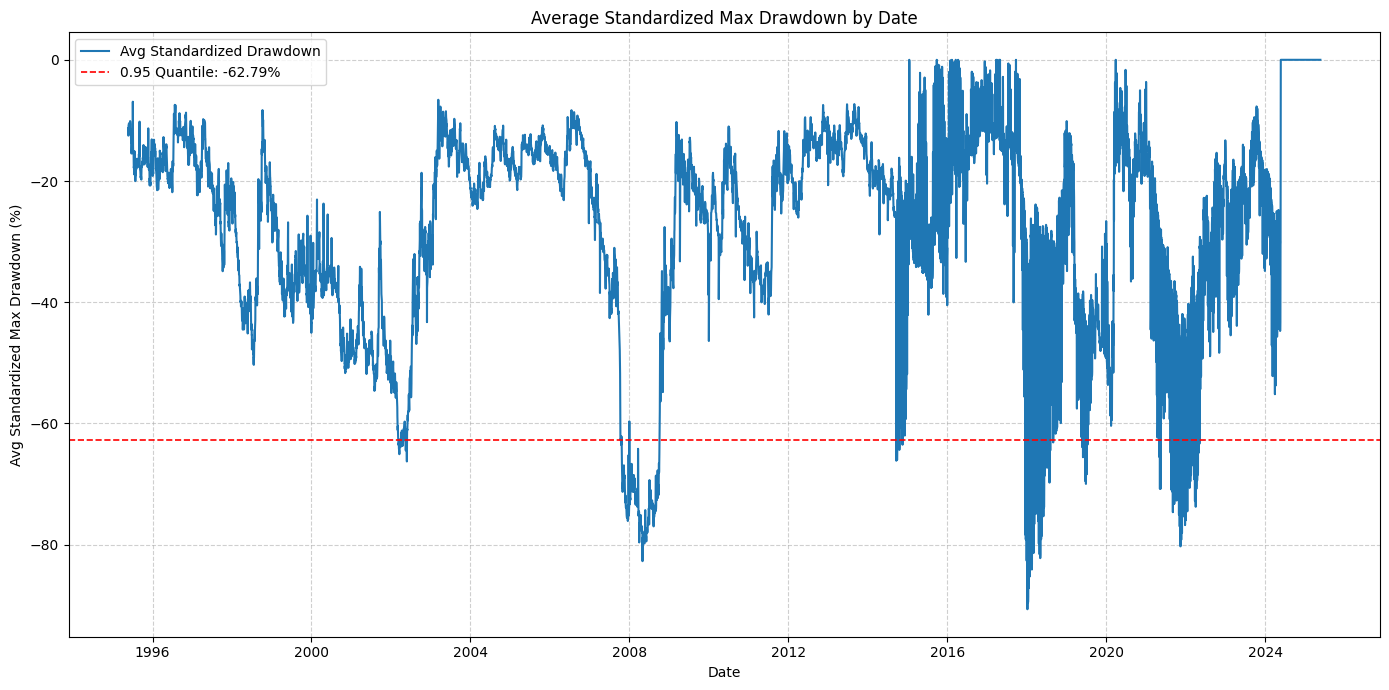

🔄 Fetching MT5 live prices...
✅ AAPL.NAS: updated MT5 Price = 201.23, Min = 198.46, Max = 242.62
✅ AAVEUSD: updated MT5 Price = 258.68, Min = 94.40, Max = 307.22
✅ ABBV.NYSE: updated MT5 Price = 182.34, Min = 163.32, Max = 200.64
✅ ABNB.NAS: updated MT5 Price = 127.55, Min = 116.22, Max = 147.76
✅ ABT.NYSE: updated MT5 Price = 131.39, Min = 102.09, Max = 131.93
✅ ACN.NYSE: updated MT5 Price = 316.20, Min = 288.85, Max = 366.54
✅ ADAUSD: updated MT5 Price = 0.8230, Min = 0.3435, Max = 0.9928
✅ ADBE.NAS: updated MT5 Price = 413.95, Min = 382.93, Max = 558.93
✅ ADS.XE: updated MT5 Price = 217.671, Min = 212.516, Max = 245.042
✅ AI.EPA: updated MT5 Price = 185.25, Min = 156.38, Max = 176.24
✅ AIR.EPA: updated MT5 Price = 161.13, Min = 128.92, Max = 164.50
✅ ALGOUSD: updated MT5 Price = 0.2409, Min = 0.1193, Max = 0.3816
✅ ALV.XE: updated MT5 Price = 350.98, Min = 259.76, Max = 351.68
✅ AMD.NAS: updated MT5 Price = 110.57, Min = 98.68, Max = 164.14
✅ AMZN.NAS: updated MT5 Price = 202.99, Mi

In [2]:
import os
import yaml
from data_fetcher import YahooFinanceDataFetcher
from mt5_fetcher import MT5DataFetcher
from google_sheet_api import GoogleSheetsUploader
from analyzer import run_analysis, run_all_analyses

# === Setup Paths === #
BASE_DIR = os.getcwd()
CONFIG_PATH = os.path.join(BASE_DIR, "config.yaml")
CREDENTIAL_PATH = os.path.join(BASE_DIR, "credential_google_sheets.json")
PLOTS_DIR = os.path.join(BASE_DIR, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

# === Load Configuration === #
def load_config(path):
    with open(path, "r") as file:
        return yaml.safe_load(file)

config = load_config(CONFIG_PATH)

# === Extract Parameters with Defaults === #
fetch_mt5 = config.get("fetch_mt5", True)
params = {
    "std_multiplier": config.get("std_multiplier", 1.96),
    "initial_balance": config.get("initial_balance", 1000),
    "invest_per_week": config.get("invest_per_week", 100),
    "leverage": config.get("leverage", 1000),
    "min_years_required": config.get("min_years_required", 1)
}

def main():
    print("📥 Fetching data from Yahoo Finance...")
    fetcher = YahooFinanceDataFetcher(CONFIG_PATH)
    full_df = fetcher.get_data()
    symbol_list = full_df["Symbol"].unique()

    # Run analysis for one example symbol
    symbol = "GOOGL.NAS"
    df, dd_thresh, gain_thresh, daily_chg = run_analysis(
        df=full_df,
        symbol=symbol,
        plots_dir=PLOTS_DIR,
        coeff=fetcher.coeff_map.get(symbol),
        **params
    )
    
    # Run all symbol analyses
    df_summary, df_final = run_all_analyses(
        full_df=full_df,
        symbol_list=symbol_list,
        plots_dir=PLOTS_DIR,
        coeff_map=fetcher.coeff_map,
        **params
    )

    # Optionally fetch live prices from MT5
    if fetch_mt5:
        print("🔄 Fetching MT5 live prices...")
        df = MT5DataFetcher(df_summary, params["min_years_required"])

    # Upload results to Google Sheets
    try:
        print("📤 Uploading to Google Sheets...")
        uploader = GoogleSheetsUploader(CREDENTIAL_PATH, "Financial Report - Indonesia")
        uploader.upload_dataframe(df, "Overview", replace=False)
        print("✅ Upload successful!")
    except Exception as e:
        print(f"❌ Upload failed: {e}")

if __name__ == "__main__":
    main()